In [18]:
import nestpy
import numpy as np
import matplotlib.pyplot as plt
import time

In [19]:
# NEST 2.0.1
def NESTv2p01_LyQy(energy, dfield, density, nuis=[1,0,1,0], fp=[50, 0.01]):
    density0 = 2.90 
    Param = [11.,1.1,0.0480,-0.0533,12.6,0.3,2.,0.3,2.,0.5,1.,1.]
    Nq = Param[0] * np.power(energy, Param[1])
    ThomasImel = Param[2] * np.power(dfield, Param[3]) * np.power(density / density0, 0.3)
    Qy = 1. / (ThomasImel*np.power(energy+Param[4],Param[9]))
    Qy *= 1. - 1. / np.power(1. + np.power((energy / Param[5]), Param[6]),Param[10])
    Ly = Nq / energy - Qy
    Qy[Qy<0]=0
    Ly[Ly<0]=0    
    Ly = Ly*(1. - 1. / np.power(1. + np.power((energy / Param[7]), Param[8]),Param[11]));
    Ly = Ly*(nuis[0]+ nuis[1]*(energy-2))
    #Qy = Qy*(nuis[2]+ nuis[3]/energy)
    Qy = Qy*(nuis[2]+ nuis[3]*(energy-1))

    return Ly, Qy


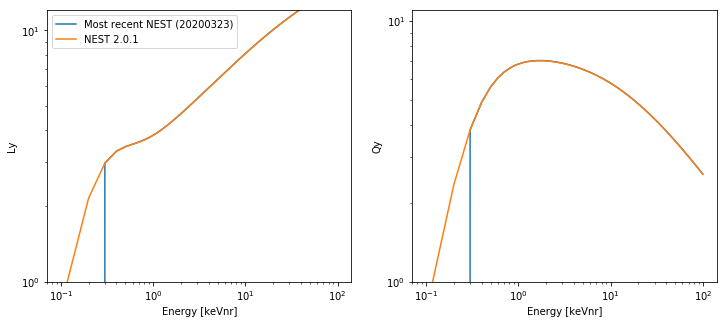

In [20]:
# This is same as C++ NEST with naming
# ** NEED TO ADD LINK WITH HELP FOR VARIOUS CALLS
detector = nestpy.DetectorExample_LUX_RUN03()
nc = nestpy.NESTcalc(detector)

interaction = nestpy.INTERACTION_TYPE(0)  # NR

Er = np.linspace(0.1, 100, 1000)
Ly = np.zeros(len(Er))
Qy = np.zeros(len(Er))
for i in range(len(Er)):
    y = nc.GetYields(interaction, Er[i], density=2.9, drift_field=180)
    Ly[i] = y.PhotonYield/Er[i]
    Qy[i] = y.ElectronYield/Er[i]
    
mLy, mQy = NESTv2p01_LyQy(Er, dfield=180, density=2.9)


plt.figure(figsize=[12,5])
plt.subplot(121)
plt.plot(Er, Ly, label='Most recent NEST (20200323)')
plt.plot(Er, mLy, label='NEST 2.0.1')
plt.legend()
plt.xlabel('Energy [keVnr]')
plt.ylabel('Ly')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1, 12])
plt.subplot(122)
plt.plot(Er, Qy)
plt.plot(Er, mQy)

plt.ylabel('Qy')
plt.xscale('log')
plt.xlabel('Energy [keVnr]')
plt.yscale('log')
plt.ylim([1, 11])
plt.show()
              

In [21]:

#create detector
detector = nestpy.DetectorExample_LUX_RUN03()

# inspect detector parameters
# # feel free to inspect more
z_max = detector.get_TopDrift() 
radius = detector.get_radius() # right fid radius?? TBD
dt_min = detector.get_dt_min() # right min dt?? TBD
dt_max = detector.get_dt_max() # right max dt?? TBD
anode = detector.get_anode()
cathode = detector.get_cathode()
T_Kelvin = detector.get_T_Kelvin() 
p_bar = detector.get_p_bar() 

print('T_Kelvin:', T_Kelvin)
print('radius:', radius)
print('dt_min:', dt_min)
print('dt_max:', dt_max)
print('anode:', anode)
print('cathode:', cathode)
print('T_Kelvin:', T_Kelvin)
print('p_bar:', p_bar)

T_Kelvin: 173.0
radius: 200.0
dt_min: 80.0
dt_max: 130.0
anode: 549.2
cathode: 55.9
T_Kelvin: 173.0
p_bar: 1.57


In [22]:
# run a single recoil
keV=10
type_num = nestpy.INTERACTION_TYPE(0) # NR
pos_x, pos_y, pos_z = 0., 0., z_max/2.
inField=180

obs = nestpy.runNEST(detector, keV, type_num, inField, pos_x, pos_y, pos_z, seed=0)
s1c_phd = obs.s1c_phd
s2c_phd = obs.s2c_phd
print(s1c_phd, s2c_phd)

6.532790408546776 590.173217059425


In [23]:
# run many recoils with vectorized arguments

# somehow detector is deleted once runNEST is finished
# just declare it again here
detector = nestpy.DetectorExample_LUX_RUN03()

n_events=1000
keV=np.linspace(0, 100, n_events)
type_num = nestpy.INTERACTION_TYPE(0) # NR

r = np.random.uniform(low=0, high=radius, size=n_events)
phi = np.random.uniform(low=0, high=2*np.pi, size=n_events)
pos_x = r * np.cos(phi);
pos_y = r * np.sin(phi);
pos_z = np.random.uniform(low=0, high=z_max, size=n_events)

inField=180
obs_arr = nestpy.runNEST_vec(detector, keV.tolist(), type_num, inField, pos_x.tolist(), pos_y.tolist(), pos_z.tolist(), 0)
s1 = obs_arr.s1c_phd
s2 = obs_arr.s2c_phd


/Users/xinxiang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


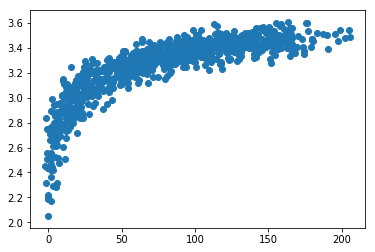

In [24]:
plt.scatter(s1, np.log10(s2))
plt.show()

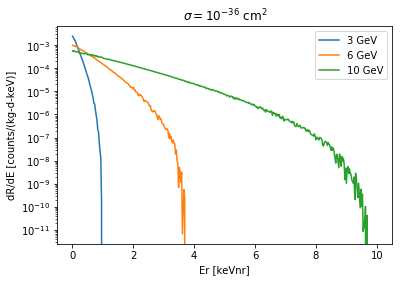

In [25]:
# NEST WIMP spectrum comes from: 
# Phys. Rev. D 82 (2010) 023530 (McCabe)

Er = np.linspace(0.01, 10, 400)

spec = nestpy.TestSpectra()
WIMP_dRate_vec = np.vectorize(spec.WIMP_dRate)


dR_3GeV = WIMP_dRate_vec(Er, m_GeV=3)
dR_6GeV = WIMP_dRate_vec(Er, m_GeV=6)
dR_10GeV = WIMP_dRate_vec(Er, m_GeV=10)

plt.plot(Er, dR_3GeV, label='3 GeV')
plt.plot(Er, dR_6GeV, label='6 GeV')
plt.plot(Er, dR_10GeV, label='10 GeV')
plt.legend()
plt.yscale('log')
plt.title('$\sigma=10^{-36}$ cm$^2$')
plt.xlabel('Er [keVnr]')
plt.ylabel('dR/dE [counts/(kg-d-keV)]')
plt.show()
